### Install

In [72]:
import os
import sys

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder



from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [2]:
RAW_DATA_DIR = "data"
DATASET_PATH = f"data/bank/bank-full.csv"

## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the Bank Marketing dataset. Download it from [here](https://archive.ics.uci.edu/static/public/222/bank+marketing.zip).

You can do it with `wget`:

```bash
wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
unzip bank+marketing.zip 
unzip bank.zip
```

We need `bank-full.csv`.

In this dataset the target variable is `y` variable - has the client subscribed a term deposit or not. 


In [3]:
!unzip bank+marketing.zip -d data

Archive:  bank+marketing.zip
 extracting: data/bank.zip           
 extracting: data/bank-additional.zip  


In [5]:
!unzip data/bank.zip -d data/bank

Archive:  data/bank.zip
  inflating: data/bank/bank-full.csv  
  inflating: data/bank/bank-names.txt  
  inflating: data/bank/bank.csv      


In [6]:
!ls -lh data/bank

total 4,9M
-rw-r--r-- 1 aztleclan aztleclan 451K feb 14  2012 bank.csv
-rw-r--r-- 1 aztleclan aztleclan 4,4M feb 14  2012 bank-full.csv
-rw-r--r-- 1 aztleclan aztleclan 3,8K feb 14  2012 bank-names.txt


### Dataset preparation

For the rest of the homework, you'll need to use only these columns:

* `'age'`,
* `'job'`,
* `'marital'`,
* `'education'`,
* `'balance'`,
* `'housing'`,
* `'contact'`,
* `'day'`,
* `'month'`,
* `'duration'`,
* `'campaign'`,
* `'pdays'`,
* `'previous'`,
* `'poutcome'`,
* `'y'`



Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [3]:
df = pd.read_csv(DATASET_PATH, sep=";")

In [4]:
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
df.y = (df.y == 'yes').astype(int)

In [6]:
df.y.value_counts()

y
0    39922
1     5289
Name: count, dtype: int64

In [7]:
seed=1

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=seed)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=seed)

In [9]:
# Reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Y
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

# Remove y
df_train = df_train.drop(columns=['y'])
df_val = df_val.drop(columns=['y'])
df_test = df_test.drop(columns=['y'])

In [10]:
print(f"df :{len(df)}, train :{len(df_train)} ({len(df_train)/len(df):.2f})%")
print(f"df :{len(df)}, val   :{len(df_val)} ({len(df_val)/len(df):.2f})%")
print(f"df :{len(df)}, test  :{len(df_test)} ({len(df_test)/len(df):.2f})%")

df :45211, train :27126 (0.60)%
df :45211, val   :9042 (0.20)%
df :45211, test  :9043 (0.20)%


In [11]:
numeric_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [12]:
categorical_columns = [
    "job",
    "marital", 
    "education", 
    "default",
    "housing",
    "loan", 
    "contact",
    "month",
    "poutcome"
]

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `y` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `balance`
- `day`
- `duration`
- `previous`

https://github.com/DevJadhav/ml-zoomcamp/blob/main/04-evaluation/homework-4.ipynb

In [31]:
highest_auc = 0
best_variable = None

auc_values = {}

for col in numeric_columns:
    auc = roc_auc_score(y_train, df_train[col])
    #print(auc)
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
        #print("lower than 0.5", auc)
    auc_values[col] = auc
    print(f"feature: {col}, auc={auc:.3f}")

best_variable = max(auc_values, key=auc_values.get)
highest_auc = auc_values[best_variable]
print(f"The numerical variable with the highest AUC is: {best_variable}={highest_auc:0.3f}")

feature: age, auc=0.512
feature: balance, auc=0.589
feature: day, auc=0.526
feature: duration, auc=0.815
feature: campaign, auc=0.571
feature: pdays, auc=0.590
feature: previous, auc=0.599
The numerical variable with the highest AUC is: duration=0.815


Which numerical variable (among the following 4) has the highest AUC?

- `balance`
- `day`
- **`duration`** <strong style="font-size: 24px;">&larr;</strong>
- `previous` 

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89
- 0.99



In [40]:
# Aplicar DictVectorizer
vec = DictVectorizer(sparse=False)

# Convertir a diccionarios para DictVectorizer
X_train_dict = df_train[categorical_columns].to_dict(orient='records')
X_val_dict = df_val[categorical_columns].to_dict(orient='records')
X_test_dict = df_test[categorical_columns].to_dict(orient='records')

X_train_encoded = np.concatenate([df_train[numeric_columns].values, vec.fit_transform(X_train_dict)], axis=1)
X_val_encoded = np.concatenate([df_val[numeric_columns].values, vec.transform(X_val_dict)], axis=1)
X_test_encoded = np.concatenate([df_test[numeric_columns].values, vec.transform(X_test_dict)], axis=1)


X_train_dict = df_train.to_dict(orient='records')
X_val_dict = df_val.to_dict(orient='records')

X_train_encoded = vec.fit_transform(X_train_dict)
X_val_encoded = vec.transform(X_val_dict)



In [41]:
# Model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
# Train model
model.fit(X_train_encoded, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [42]:
# Evaluate mode
y_val_pred_proba = model.predict_proba(X_val_encoded)[::,1]
#score = accuracy_score(y_val, y_val_proba >= 0.5)

#calculate AUC of model
auc = roc_auc_score(y_val, y_val_pred_proba)

#print AUC score
print(round(auc, 3))

0.901


In [ ]:
# 7. Graficar precisión y recuperación
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precisión', color='blue')
plt.plot(thresholds, recalls, label='Recuperación', color='orange')
plt.title('Precisión y Recuperación vs. Umbral')
plt.xlabel('Umbral')
plt.ylabel('Valor')
plt.legend()
plt.grid()
plt.show()


- 0.69
- 0.79
- **0.89** <strong style="font-size: 24px;">&larr;</strong>
- 0.99 

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.265
* 0.465
* 0.665
* 0.865

In [94]:
def precision_recall_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0

        f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

        scores.append((t, precision, recall, f1_score))

    columns = ['threshold', 'precision', 'recall', 'f1_score']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [56]:
df_lr = precision_recall_dataframe(y_val, y_val_pred_proba)

In [57]:
df_lr.head(5)

,threshold,precision,recall,f1_score
0,0.00,0.121433,1.000000,0.216568
1,0.01,0.136562,0.996357,0.240202
2,0.02,0.160972,0.995446,0.277130
3,0.03,0.189048,0.987250,0.317330
4,0.04,0.222268,0.974499,0.361976


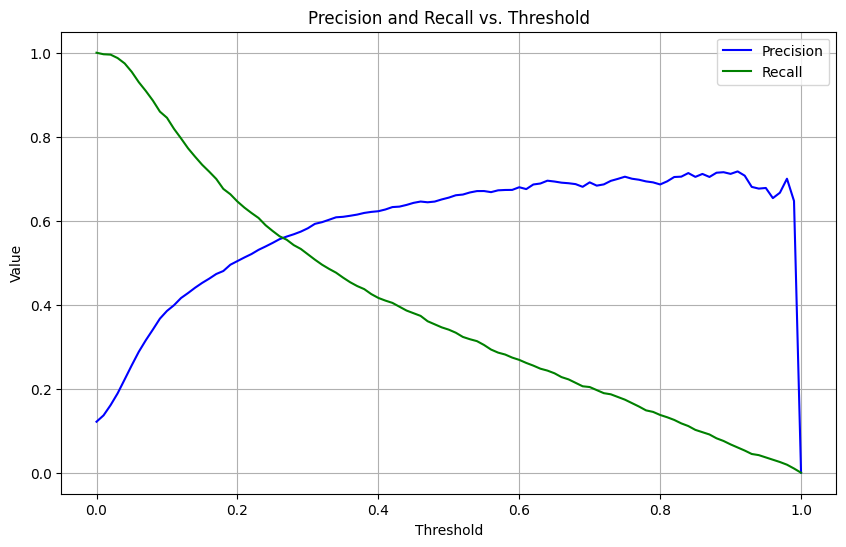

Precision and recall intersect at threshold: 0.260


In [71]:
thresholds = df_lr['threshold'].values
precisions = df_lr['precision'].values
recalls = df_lr['recall'].values

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Find the threshold where precision and recall intersect
intersect_threshold_idx = np.where(np.abs(np.array(precisions) - np.array(recalls)) < 0.01)[0]
intersect_threshold = thresholds[intersect_threshold_idx][0]
print(f"Precision and recall intersect at threshold: {intersect_threshold:.3f}")

At which threshold precision and recall curves intersect?

* **0.265** <strong style="font-size: 24px;">&larr;</strong>
* 0.465
* 0.665
* 0.865

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62

https://github.com/DevJadhav/ml-zoomcamp/blob/main/04-evaluation/homework-4.ipynb

In [73]:
df_lr.iloc[15:25]

,threshold,precision,recall,f1_score
15,0.15,0.451993,0.733151,0.559222
16,0.16,0.462126,0.716758,0.561942
17,0.17,0.473198,0.699454,0.564498
18,0.18,0.480259,0.675774,0.561483
19,0.19,0.495238,0.663024,0.566978
20,0.20,0.503909,0.645719,0.566068
21,0.21,0.512574,0.631148,0.565714
22,0.22,0.520706,0.618397,0.565362
23,0.23,0.530677,0.606557,0.566086
24,0.24,0.538718,0.589253,0.562853


In [74]:
max_f1_idx = df_lr['f1_score'].argmax()
max_f1 = df_lr['f1_score'][max_f1_idx]
max_f1_threshold = df_lr['threshold'][max_f1_idx]
print(f"({max_f1_idx} max f1-score: {max_f1:.3f}) with threshold: {max_f1_threshold}")

(19 max f1-score: 0.567) with threshold: 0.19


At which threshold F1 is maximal?

- 0.02
- **0.22** <strong style="font-size: 24px;">&larr;</strong>
- 0.42
- 0.62

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26

In [92]:
df_full_train.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
22468,52,management,married,tertiary,no,0,no,no,cellular,22,aug,232,2,-1,0,unknown,0
6896,50,admin.,single,secondary,no,330,yes,no,unknown,28,may,24,1,-1,0,unknown,0
28408,45,blue-collar,married,primary,no,300,yes,no,cellular,29,jan,203,1,261,3,failure,0
8481,38,technician,married,secondary,no,27,yes,no,unknown,3,jun,404,4,-1,0,unknown,0
28753,31,services,single,secondary,no,887,no,no,cellular,30,jan,427,1,-1,0,unknown,0


In [103]:
def kfold_lr(
    df_train,
    n_splits=5,
    c=1.0
):
    # Kfold
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
    # Store the AUC scores for each fold
    auc_scores = {}
    
    for n_fold, (train_idx, val_idx) in enumerate(kfold.split(df_train)):
        # X feactures
        X_train = df_train.iloc[train_idx]
        X_val = df_train.iloc[val_idx]
        # Y values
        y_train = X_train.y.values
        y_val = X_val.y.values
        # Remove y
        del X_train['y']
        del X_val['y']
            
        # Preproessing
        X_train_dict = X_train.to_dict(orient='records')
        X_val_dict = X_val.to_dict(orient='records')
        X_train_encoded = vec.fit_transform(X_train_dict)
        X_val_encoded = vec.transform(X_val_dict)
        
        # Train
        model_fold_lr = LogisticRegression(
            solver='liblinear', C=c, max_iter=1000
        )
        model_fold_lr.fit(X_train_encoded, y_train)
    
        # Predict
        y_val_pred_proba = model_fold_lr.predict_proba(X_val_encoded)[::,1]
    
        # Calculate metrics
        auc = roc_auc_score(y_val, y_val_pred_proba)
        print(f"fold: {n_fold}, auc: {auc}")
        auc_scores[n_fold] = auc
    
    # Return scores
    return auc_scores

In [104]:
auc_scores = kfold_lr(
    df_full_train,
    n_splits=5,
    c=1.0
)

fold: 0, auc: 0.8998636821956679
fold: 1, auc: 0.9011043010899575
fold: 2, auc: 0.9116863227865895
fold: 3, auc: 0.908721062604314
fold: 4, auc: 0.9129330979152199


In [107]:
auc_scores.values()

dict_values([0.8998636821956679, 0.9011043010899575, 0.9116863227865895, 0.908721062604314, 0.9129330979152199])

In [108]:
# Compute the standard deviation of AUC scores
std_dev = np.std(list(auc_scores.values()))

print(f"Standard deviation of AUC scores across 5 folds: {std_dev:.3f}")

Standard deviation of AUC scores across 5 folds: 0.005


How large is standard deviation of the scores across different folds?

- 0.0001
- **0.006** <strong style="font-size: 24px;">&larr;</strong>
- 0.06
- 0.26

### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.


In [110]:
hyper_scores=[]
for c in [0.000001, 0.001, 1]:

    auc_scores = kfold_lr(
        df_full_train,
        n_splits=5,
        c=c
    )
    auc_score_values = list(auc_scores.values())
    print('C=%s %.3f +- %.3f' % (c, np.mean(auc_score_values), np.std(auc_score_values)))
    hyper_scores.append((c, np.mean(auc_score_values), np.std(auc_score_values)))

fold: 0, auc: 0.6848617232878531
fold: 1, auc: 0.7002138629971479
fold: 2, auc: 0.7121908752074435
fold: 3, auc: 0.7088365957975271
fold: 4, auc: 0.7017754244174879
C=1e-06 0.702 +- 0.009
fold: 0, auc: 0.8526599819478977
fold: 1, auc: 0.8637691569790826
fold: 2, auc: 0.8676784542929087
fold: 3, auc: 0.8745670798138674
fold: 4, auc: 0.8686372467900889
C=0.001 0.865 +- 0.007
fold: 0, auc: 0.8998636821956679
fold: 1, auc: 0.9011043010899575
fold: 2, auc: 0.9116863227865895
fold: 3, auc: 0.908721062604314
fold: 4, auc: 0.9129330979152199
C=1 0.907 +- 0.005


In [115]:
hyper_columns = ['C', 'Mean', 'Std']
df_hyper = pd.DataFrame(hyper_scores, columns=hyper_columns)
df_hyper['Round Mean'] = df_hyper['Mean'].round(3)
df_hyper['Round Std'] = df_hyper['Std'].round(3)
df_hyper = df_hyper.sort_values(by='Round Mean', ascending=False)

In [116]:
df_hyper[["C", "Round Mean", "Round Std"]]

,C,Round Mean,Round Std
2,1.000000,0.907,0.005
1,0.001000,0.865,0.007
0,0.000001,0.702,0.009



Which `C` leads to the best mean score?

- 0.000001
- 0.001
- **1** <strong style="font-size: 24px;">&larr;</strong>


## Submit the results

* Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2024/homework/hw04
* If your answer doesn't match options exactly, s